# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [52]:
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import cv2
# import cupy as cp
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from torch import Tensor
import albumentations as A
import torch.nn.functional as F
from scipy import ndimage as ndi

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from scipy import signal

Using 1 GPU(s)


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [53]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 5
    FOLDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    LR = 0.1
    WEIGHT_DECAY = 0.01
    backbone_2d = 'tf_efficientnet_b0'
    num_channels = 8
    pretrained = True
    
    filter_signal = False
    sampling_rate = 200
    lowcut = 0.5  # 0.85  # Нижняя граница в Hz
    highcut = 20  # 25.0  # Верхняя граница в Hz
    filter_order = 2
    
    image_transform = transforms.Resize((512,512)) 
    
    augment = False
    
    two_stage = True
    
class paths:
    OUTPUT_DIR = "1D 2D new/v70_newdata_re/"
    TRAIN_CSV = "hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "hms-harmful-brain-activity-classification/train_eegs/"
    PRE_LOADED_SPECTROGRAMS = 'brain-spectrograms/specs.npy'
    PRE_LOADED_EEGS = 'eeg-spectrogram-by-lead-id-unique/eeg_specs.npy'
    TRAIN_SPECTROGRAMS = "hms-harmful-brain-activity-classification/train_spectrograms/"
    
if not os.path.exists(paths.OUTPUT_DIR):
    os.makedirs(paths.OUTPUT_DIR)

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions.

In [61]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data

def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

# A40 80G 48G 120G 16CPU
def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    
    electrode_names = ['LL', 'RL', 'LP', 'RP']

    electrode_pairs = [
        ['Fp1', 'F7', 'T3', 'T5', 'O1'],
        ['Fp2', 'F8', 'T4', 'T6', 'O2'],
        ['Fp1', 'F3', 'C3', 'P3', 'O1'],
        ['Fp2', 'F4', 'C4', 'P4', 'O2']
    ]
    
    # Filter specifications
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq

    # Bandpass and notch filter
    bandpass_coefficients = butter(order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
    
    spec_size = duration * 200
    start = start * 200
    real_start = start + (10_000//2) - (spec_size//2)
    eeg_data = eeg_data.iloc[real_start:real_start+spec_size]
    
    
    # Spectrogram parameters
    fs = 200
    nperseg = nperseg_
    noverlap = noverlap_
    nfft = nfft_
    
    if spec_size_freq <=0 or spec_size_time <=0:
        frequencias_size = int((nfft // 2)/5.15198)+1
        segmentos = int((spec_size - noverlap) / (nperseg - noverlap)) 
    else:
        frequencias_size = spec_size_freq
        segmentos = spec_size_time
        
    spectrogram = cp.zeros((frequencias_size, segmentos, 4), dtype='float32')
    
    processed_eeg = {}

    for i, name in enumerate(electrode_names):
        cols = electrode_pairs[i]
        processed_eeg[name] = np.zeros(spec_size)
        for j in range(4):
            # Compute differential signals
            # print(cols[j])
            signal = cp.array(eeg_data[cols[j]].values - eeg_data[cols[j+1]].values)

            # Handle NaNs
            mean_signal = cp.nanmean(signal)
            signal = cp.nan_to_num(signal, nan=mean_signal) if cp.isnan(signal).mean() < 1 else cp.zeros_like(signal)
            

            # Filter bandpass and notch
            signal_filtered = filtfilt(*notch_coefficients, signal.get())
            signal_filtered = filtfilt(*bandpass_coefficients, signal_filtered)
            signal = cp.asarray(signal_filtered)
            
            frequencies, times, Sxx = cusignal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

            # Filter frequency range
            valid_freqs = (frequencies >= 0.59) & (frequencies <= 20)
            frequencies_filtered = frequencies[valid_freqs]
            Sxx_filtered = Sxx[valid_freqs, :]

            # Logarithmic transformation and normalization using Cupy
            spectrogram_slice = cp.clip(Sxx_filtered, cp.exp(-4), cp.exp(6))
            spectrogram_slice = cp.log10(spectrogram_slice)

            normalization_epsilon = 1e-6
            mean = spectrogram_slice.mean(axis=(0, 1), keepdims=True)
            std = spectrogram_slice.std(axis=(0, 1), keepdims=True)
            spectrogram_slice = (spectrogram_slice - mean) / (std + normalization_epsilon)
            
            spectrogram[:, :, i] += spectrogram_slice
            processed_eeg[f'{cols[j]}_{cols[j+1]}'] = signal.get()
            processed_eeg[name] += signal.get()
        
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        if mean_montage_names > 0:
            spectrogram[:,:,i] /= mean_montage_names

    # Convert to NumPy and apply Gaussian filter
    spectrogram_np = cp.asnumpy(spectrogram)
    if sigma_gaussian > 0.0:
        spectrogram_np = gaussian_filter(spectrogram_np, sigma=sigma_gaussian)

    # Filter EKG signal
    ekg_signal_filtered = filtfilt(*notch_coefficients, eeg_data["EKG"].values)
    ekg_signal_filtered = filtfilt(*bandpass_coefficients, ekg_signal_filtered)
    processed_eeg['EKG'] = np.array(ekg_signal_filtered)

    return spectrogram_np, processed_eeg


def create_spectogram_competition(spec_id, seconds_min):
    spec = pd.read_parquet(f'hms-harmful-brain-activity-classification/train_spectrograms/{spec_id}.parquet')
    inicio = (seconds_min) // 2
    img = spec.fillna(0).values[:, 1:].T.astype("float32")
    img = img[:, inicio:inicio+300]
    
    # Log transform and normalize
    img = np.clip(img, np.exp(-4), np.exp(6))
    img = np.log(img)
    eps = 1e-6
    img_mean = img.mean()
    img_std = img.std()
    img = (img - img_mean) / (img_std + eps)
    
    return img 


def create_512_spec(eeg_data, eeg_id, spec_id, start_second = 0, seconds_min = 0):
    image_50s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 501,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 10,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 100, spec_size_time = 291,
                                    nperseg_ = 260, noverlap_ = 254, nfft_ = 1030,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10m = create_spectogram_competition(spec_id, seconds_min)
    
    imagem_final_unico_canal = np.zeros((1068, 501))
    for j in range(4):
        inicio = j * 267 
        fim = inicio + 267
        imagem_final_unico_canal[inicio:fim, :] = image_50s[:, :, j]
        
    
    imagem_final_unico_canal2 = np.zeros((400, 291))
    for n in range(4):
        inicio = n * 100 
        fim = inicio + 100
        imagem_final_unico_canal2[inicio:fim, :] = image_10s[:, :, n]
    
    imagem_final_unico_canal_resized = cv2.resize(imagem_final_unico_canal, (400, 800), interpolation=cv2.INTER_AREA)
    imagem_final_unico_canal2_resized = cv2.resize(imagem_final_unico_canal2, (300, 400), interpolation=cv2.INTER_AREA)
    eeg_new_resized = cv2.resize(image_10m, (300, 400), interpolation=cv2.INTER_AREA)
    imagem_final = np.zeros((800, 700), dtype=np.float32)
    imagem_final[0:800, 0:400] = imagem_final_unico_canal_resized
    imagem_final[0:400,400:700] = imagem_final_unico_canal2_resized
    imagem_final[400:800, 400:700] = eeg_new_resized
    imagem_final = imagem_final[::-1]
    
    imagem_final = cv2.resize(imagem_final, (512, 512), interpolation=cv2.INTER_AREA)
    
    return imagem_final

def create_spectrogram(data):
    """This function will create the spectrograms based on the EEG data with the 'magic formula'."""
    nperseg = 150  # Length of each segment
    noverlap = 128  # Overlap between segments
    NFFT = max(256, 2 ** int(np.ceil(np.log2(nperseg))))

    # LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4
    freqs, t,spectrum_LL1 = signal.spectrogram(data[:,feature_to_index['Fp1']]-data[:,feature_to_index['F7']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL2 = signal.spectrogram(data[:,feature_to_index['F7']]-data[:,feature_to_index['T3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LL3 = signal.spectrogram(data[:,feature_to_index['T3']]-data[:,feature_to_index['T5']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LL4 = signal.spectrogram(data[:,feature_to_index['T5']]-data[:,feature_to_index['O1']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    LL = (spectrum_LL1+ spectrum_LL2 +spectrum_LL3 + spectrum_LL4)/4

    # LP Spec = ( spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1) )/4
    freqs, t,spectrum_LP1 = signal.spectrogram(data[:,feature_to_index['Fp1']]-data[:,feature_to_index['F3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP2 = signal.spectrogram(data[:,feature_to_index['F3']]-data[:,feature_to_index['C3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP3 = signal.spectrogram(data[:,feature_to_index['C3']]-data[:,feature_to_index['P3']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_LP4 = signal.spectrogram(data[:,feature_to_index['P3']]-data[:,feature_to_index['O1']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    LP = (spectrum_LP1+ spectrum_LP2 +spectrum_LP3 + spectrum_LP4)/4

    # RP Spec = ( spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2) )/4
    freqs, t,spectrum_RP1 = signal.spectrogram(data[:,feature_to_index['Fp2']]-data[:,feature_to_index['F4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP2 = signal.spectrogram(data[:,feature_to_index['F4']]-data[:,feature_to_index['C4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP3 = signal.spectrogram(data[:,feature_to_index['C4']]-data[:,feature_to_index['P4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RP4 = signal.spectrogram(data[:,feature_to_index['P4']]-data[:,feature_to_index['O2']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)


    RP = (spectrum_RP1+ spectrum_RP2 +spectrum_RP3 + spectrum_RP4)/4

    # RL Spec = ( spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2) )/4
    freqs, t,spectrum_RL1 = signal.spectrogram(data[:,feature_to_index['Fp2']]-data[:,feature_to_index['F8']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL2 = signal.spectrogram(data[:,feature_to_index['F8']]-data[:,feature_to_index['T4']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL3 = signal.spectrogram(data[:,feature_to_index['T4']]-data[:,feature_to_index['T6']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    freqs, t,spectrum_RL4 = signal.spectrogram(data[:,feature_to_index['T6']]-data[:,feature_to_index['O2']],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)

    RL = (spectrum_RL1+ spectrum_RL2 +spectrum_RL3 + spectrum_RL4)/4
    spectogram = np.concatenate((LL, LP,RP,RL), axis=0)
    return spectogram

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [62]:
train_df = pd.read_csv(paths.TRAIN_CSV)
label_cols = train_df.columns[-6:]
print(f"Train cataframe shape is: {train_df.shape}")
print(f"Labels: {list(label_cols)}")
train_df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### <b><span style='color:#F1A424'>Read one EEG parquet</span></b>

All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second,

Each EEG parquet results in a dataframe with `seconds` rows and 20 columns.

- EEG features are: `['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']`
- We will use these features: `['Fp1','T3','C3','O1','Fp2','C4','T4','O2']`



In [63]:
eeg_df = pd.read_parquet(paths.TRAIN_EEGS + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


### <b><span style='color:#F1A424'>Read all EEG parquets</span></b>

0it [00:00, ?it/s]

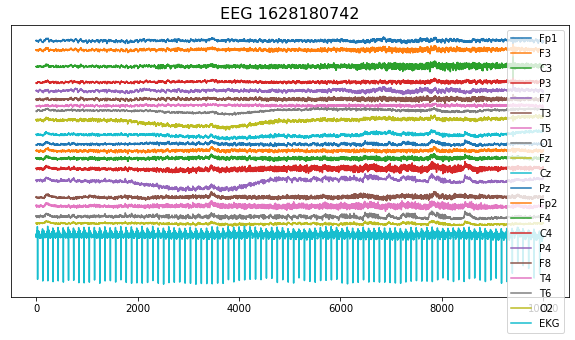

1it [00:00,  1.07it/s]


Reading 17089 eeg NumPys from disk.
CPU times: user 701 ms, sys: 13.6 s, total: 14.3 s
Wall time: 15.3 s


In [64]:
%%time

CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TRAIN_EEGS + "*.parquet")
eeg_ids = train_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TRAIN_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path, display=i<visualize)              
    all_eegs[eeg_id] = data
    
    if i == visualize:
        if CREATE_EEGS:
            print(f'Processing {train_df.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(eeg_ids)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs', all_eegs)
else:
    all_eegs = np.load('eegs.npy',allow_pickle=True).item()    

In [65]:
%%time
READ_EEG_SPEC_FILES = False

paths_eegs = glob(paths.TRAIN_EEGS + "*.npy")
print(f'There are {len(paths_eegs)} EEG spectrograms')

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for file_path in tqdm(paths_eegs):
        eeg_id = file_path.split("/")[-1].split(".")[0]
        eeg_spectogram = np.load(file_path)
        all_eegs[eeg_id] = eeg_spectogram
else:
    all_eegs_specs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()
    
print(len(all_eegs_specs))

There are 0 EEG spectrograms
20183
CPU times: user 22.1 ms, sys: 7.45 s, total: 7.47 s
Wall time: 9.28 s


# Read Train Spectrograms

There are 11138 spectrogram parquets


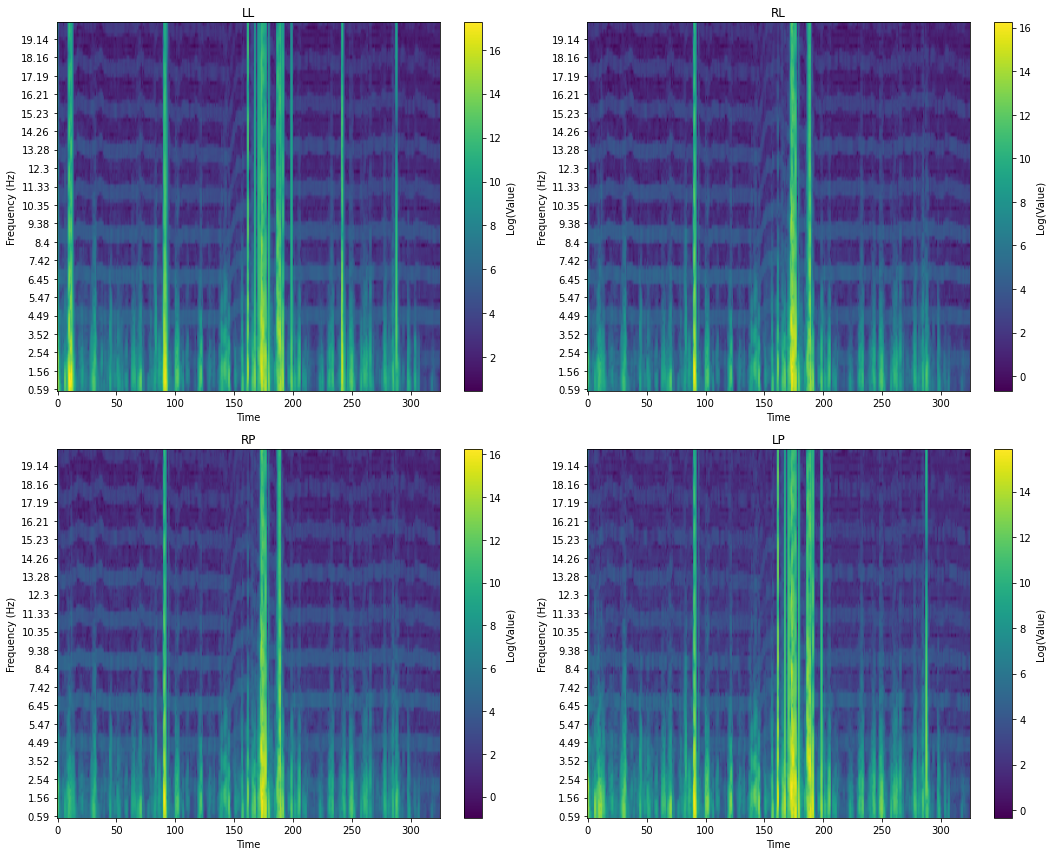

CPU times: user 1.31 s, sys: 6.79 s, total: 8.11 s
Wall time: 8.07 s


In [66]:
%%time
READ_SPEC_FILES = False

paths_spectrograms = glob(paths.TRAIN_SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')

if READ_SPEC_FILES:    
    all_spectrograms = {}
    for file_path in tqdm(paths_spectrograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:,1:].values
        del aux
else:
    all_spectrograms = np.load(paths.PRE_LOADED_SPECTROGRAMS, allow_pickle=True).item()
    
if config.VISUALIZE:
    idx = np.random.randint(0,len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)

# <b><span style='color:#F1A424'>|</span> Data pre-processing</b><a class='anchor' id='preprocessing'></a> [↑](#top) 

***

In [67]:
df = pd.read_csv('hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [69]:
train_df = df.drop_duplicates(
    subset=['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
print('Train shape', train_df.shape )

train_df['total_evaluators'] = train_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
y_data = train_df[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[TARGETS] = y_data
train_df['target'] = train_df['expert_consensus']
train_df = train_df.reset_index()
train_df.head()

Train shape (20183, 15)


/tmp/ipykernel_180014/1955847998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['total_evaluators'] = train_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
/tmp/ipykernel_180014/1955847998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[TARGETS] = y_data
/tmp/ipykernel_180014/1955847998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_evaluators,target
0,0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,Seizure
1,9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,11,GPD
2,11,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,16,LRDA
3,22,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,3,LRDA
4,28,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,Seizure


In [71]:
# def datasetwide_mean(eeg_ids):
#     """This function will calculate the mean of the entire dataset."""
#     data_means = []
#     total_values = 0
#     # Iterate over each path in the provided paths
#     for eeg_id in tqdm(eeg_ids):
#         # Read data from parquet file
#         data = all_eegs[eeg_id]
#         data = create_spectrogram(data)
        
#         # Fill missing values with the specified constant
#         mask = np.isnan(data)
#         data[mask] = -1
        
#         # Clip values and apply logarithmic transformation
#         data = np.clip(data, np.exp(-6), np.exp(10))
#         data = np.log(data)
        
#         # Calculate sum and amount of values of the data
#         data_sum = data.sum(axis=(0, 1))
#         rows,columns = data.shape
#         total_values += rows*columns
        
#     return data_sum/total_values

# def datasetwide_std(eeg_ids, mean):
#     """This function will calculate the standard deviation of the entire dataset."""
#     data_stds = []
#     # Iterate over each path in the provided paths
#     sum_std = 0
#     total_values = 0
#     for eeg_id in tqdm(eeg_ids):
#         # Read data from parquet file
#         data = all_eegs[eeg_id]
#         data = create_spectrogram(data)
        
#         # Fill missing values with the specified constant
#         mask = np.isnan(data)
#         data[mask] = -1

#         # Clip values and apply logarithmic transformation
#         data = np.clip(data, np.exp(-6), np.exp(10))
#         data = np.log(data)
        
#         # Calculate values needed for std
#         sum_std+= np.sum((data-mean)**2)
#         rows,columns = data.shape
#         total_values += rows*columns
    
#     return np.sqrt(sum_std/(total_values-1))

# # Calculate the mean and std of dataset. 
# data_mean = datasetwide_mean(train_df['eeg_id'].values)
# data_std = datasetwide_std(train_df['eeg_id'].values, data_mean)
# print(data_mean, data_std)

# unique
data_mean = 0.00011579196009429602
data_std = 4.5827806440634316

# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

We train using `GroupKFold` on `patient_id`.

In [72]:
from sklearn.model_selection import KFold, GroupKFold


gkf = GroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size()), sep()
display(train_df.head())

fold
0.0    4037
1.0    4037
2.0    4037
3.0    4036
4.0    4036
dtype: int64

----------------------------------------------------------------------------------------------------


,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_evaluators,target,fold
0,0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,Seizure,0.0
1,9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,11,GPD,3.0
2,11,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,16,LRDA,2.0
3,22,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,3,LRDA,2.0
4,28,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,Seizure,2.0


# <b><span style='color:#F1A424'>|</span> Butter Low-Pass Filter</b><a class='anchor' id='filter'></a> [↑](#top) 

***

- [scipy.signal.butter()][1]
- [scipy.signal.lfilter()][2]

[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter
[2]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter

In [73]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

## <b><span style='color:#F1A424'>Visualize</span></b>


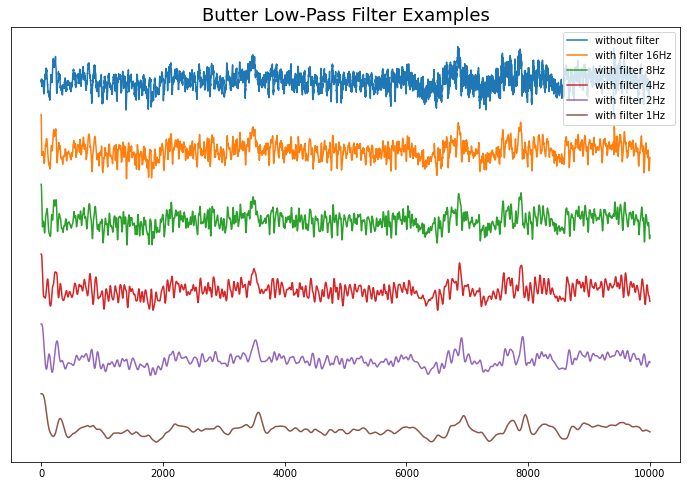

In [74]:
frequencies = [1,2,4,8,16][::-1] # frequencies in Hz
x = [all_eegs[eeg_ids[0]][:,0]] # select one EEG feature

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

In [75]:
# from scipy.signal import butter, filtfilt, iirnotch
# import cusignal

ALL_EEGS_512_SPEC_CREATE = False

if ALL_EEGS_512_SPEC_CREATE:
    all_eegs_512_spec = {}
    # for i, eeg_id in tqdm(enumerate(eeg_ids)): 
    for index in tqdm(train_df.index):
        row = train_df.iloc[index]
        eeg_id = row['eeg_id']
        spec_id = row['spectrogram_id']
        # eeg_data = all_eegs[row['eeg_id']]
        eeg_data = pd.read_parquet(f'hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')
        all_eegs_512_spec[str(eeg_id)] = create_512_spec(eeg_data, eeg_id, spec_id)
        np.savez_compressed('all_eegs_512_spec_unique.npz', **all_eegs_512_spec)
else:
    all_eegs_512_spec = np.load('all_eegs_512_spec_unique.npz')

# aotudl A40 80G内存 48G显存 120G存储 26CPU 一个月5000

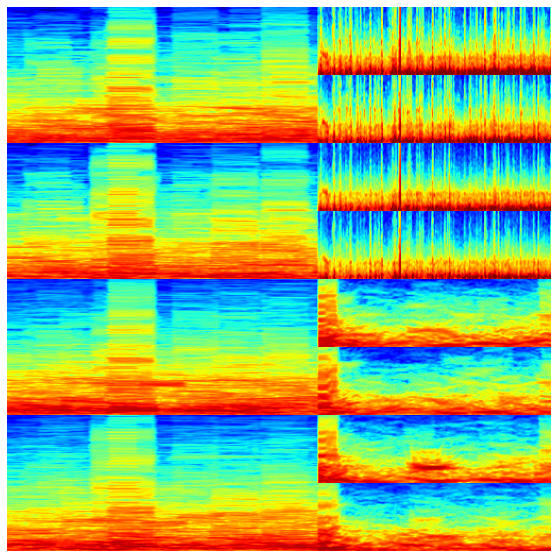

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(all_eegs_512_spec['568657'], cmap='jet')
plt.axis('off')
plt.show()

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

- [How to Convert EEG to Spectrograms][1]: to understand the feature engineering performed in the generation method.
- [How To Create Spectrogram From Eeg?][2]: original post on how to create Spectrograms from EEGs.
- [Introduction to EEG][3]: short video to better understand EEGs.

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[3]: https://www.youtube.com/watch?v=XMizSSOejg0

In [77]:
class CustomDataset(Dataset):
    def __init__(
        self, df, config, mode='train', eegs=all_eegs, specs=all_spectrograms, eeg_specs=all_eegs_specs, downsample=5, augment=config.augment, data_mean=data_mean, data_std=data_std
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.mode = mode
        self.eegs = eegs
        self.spectrograms = specs
        self.eeg_spectrograms = eeg_specs
        self.all_eegs_512_spec = all_eegs_512_spec
        self.downsample = downsample
        self.augment = augment
        self.data_mean = data_mean
        self.data_std = data_std
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X_eeg, X_spec, y = self.__data_generation(index)
            
        # X_eeg = X_eeg[::self.downsample,:]
        output = {
            "X_eeg": torch.tensor(X_eeg, dtype=torch.float32),
            "X_spec": torch.tensor(X_spec, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        
        X_eeg = self.__eeg_data_gen(row)
        X_spec = self.__spec_data_gen(row)
        
        y = np.zeros(6, dtype='float32')
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X_eeg, X_spec, y
    

    def get_datasetwidenorm(self, eeg_id):
        """This function will get the batch and preprocess it."""
        # Set a small epsilon to avoid division by zero
        eps = 1e-6

        # Read data from parquet file
        data = all_eegs[eeg_id]
        data = create_spectrogram(data)

        # Fill missing values with the specified constant
        mask = np.isnan(data)
        data[mask] = -1

        # Clip values and apply logarithmic transformation
        data = np.clip(data, np.exp(-6), np.exp(10))
        data = np.log(data)

        # Normalize the data
        data = (data - self.data_mean) / (self.data_std + eps)

        # Convert data to a PyTorch tensor and apply transformations
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data = config.image_transform(data_tensor)

        # Return the batch data
        return data.numpy()
    
    def __eeg_data_gen(self, row):
        X = np.zeros((10_000, 8), dtype='float32')
        data = self.eegs[row.eeg_id]
        
        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]
        
        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)

        return X
    
    def __spec_data_gen(self, row):
        """
        Generates spec data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        img = np.ones((128,256), dtype='float32')
        if self.mode=='test': 
            r = 0
        else: 
            r = int(row['spectrogram_label_offset_seconds'] // 2)
            
        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectrograms[row.label_id]
            X[:, :, 4:] = img
        
        # === Get spectrograms ===
        spectrograms = np.concatenate([X[:, :, i:i+1] for i in range(4)], axis=0) #[512, 256, 1]
        
        # === Get EEG spectrograms ===
        eegs = np.concatenate([X[:, :, i:i+1] for i in range(4, 8)], axis=0) #[512, 256, 1]
        # eegs = np.transpose(eegs, (2, 0, 1))
        
        X = np.concatenate([spectrograms, eegs], axis=1) #[512, 512, 1]
        X = np.transpose(X, (2, 0, 1)) #[1, 512, 512]

        spec = self.all_eegs_512_spec[str(row['eeg_id'])] #[512, 512]
        spec = spec[np.newaxis, :, :] #[1, 512, 512]
        
        new_norm = self.get_datasetwidenorm(row['eeg_id']) #[1, 512, 512]
        # print(new_norm.shape)
        
        # # v54 [3, 1536, 512]
        # X = np.concatenate([X, spec, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v53 [3, 512, 512]
        # X = np.concatenate([X, spec, spec], axis=0)
        
        # # v55 [3, 1024, 512]
        # X = np.concatenate([X, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v66 [3, 512, 1536]
        # X = np.concatenate([X, X, spec], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
        # # v67
        # X = np.concatenate([spectrograms, eegs, spec], axis=0)
        
        # # v68
        # X = np.concatenate([X, spec, new_norm], axis=0)
        
        # v69
        X = np.concatenate([X, spec, new_norm], axis=1) # #[1, 1536, 512]
        X = np.tile(X, (3, 1, 1)) #[3, 1536, 512]

        # # v72
        # X = np.concatenate([new_norm, spec, new_norm], axis=1)
        # X = np.tile(X, (3, 1, 1))
        
#         # v73
#         X = np.concatenate([new_norm, spec, eegs], axis=2)
#         X = np.tile(X, (3, 1, 1))
        
        return X

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

In [78]:
train_dataset = CustomDataset(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X_eeg, X_spec, y = output["X_eeg"], output["X_spec"], output["y"]
print(f"X_eeg shape: {X_eeg.shape}")
print(f"X_spec shape: {X_spec.shape}")
print(f"y shape: {y.shape}")

X_eeg shape: torch.Size([10000, 8])
X_spec shape: torch.Size([3, 1536, 512])
y shape: torch.Size([6])


In [79]:
class iAFF(nn.Module):
    '''
    多特征融合 iAFF
    '''

    def __init__(self, channels=6, r=2):
        super(iAFF, self).__init__()
        inter_channels = int(channels // r)

        # 局部注意力
        self.local_att = nn.Sequential(
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        # 全局注意力
        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        # 第二次局部注意力
        self.local_att2 = nn.Sequential(
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )
        # 第二次全局注意力
        self.global_att2 = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(channels),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, residual):
        xa = x + residual
        # print(xa.shape)  [2, 3, 128]
        xl = self.local_att(xa)
        xg = self.global_att(xa)
        # print(xl.shape)  [2, 3, 128]
        # print(xg.shape)  [2, 3, 1]
        xlg = xl + xg
        wei = self.sigmoid(xlg)
        xi = x * wei + residual * (1 - wei)

        xl2 = self.local_att2(xi)
        xg2 = self.global_att(xi)
        xlg2 = xl2 + xg2
        wei2 = self.sigmoid(xlg2)
        xo = x * wei2 + residual * (1 - wei2)
        return xo


In [80]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out

In [82]:
import timm

class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGMegaNet, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        
        # 1d eeg CNN
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)
        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)

        self.iaaf = iAFF(channels=3, r=1)

        
        # 2D efficient
        self.backbone_2d = timm.create_model(
            config.backbone_2d,
            pretrained=config.pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        
        )
        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2])
        self.avg_pool_2d = nn.AdaptiveAvgPool2d(1)
        self.flatten_2d = nn.Flatten()
            
        # forward
        self.fc1 = nn.Linear(in_features=self.backbone_2d.num_features, out_features=128)
        self.fc2 = nn.Linear(in_features=736, out_features=128)

    
        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)

        self.flatten_final = nn.Flatten()
        self.fc = nn.Linear(in_features=128*3, out_features=num_classes)
        
        
    def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)
    

    def forward(self, x, spec):
        # spec efficientB0
        # spec = self.__reshape_input(spec)
        # spec = spec.unsqueeze(1).repeat(1,3,1,1)
        # print(spec.shape)

        spec = self.features_2d(spec)
        # print(spec.shape)
        spec = self.avg_pool_2d(spec)
        # print(spec.shape)
        spec = self.flatten_2d(spec)
        # print(spec.shape)
        
        spec_emb = self.fc1(spec)
        outspec = self.fc2d(spec_emb)
        # print(spec_emb.shape)
        
        # 1D CNN
        x = x.permute(0, 2, 1)
        
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  
 
        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out) 

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]
        new_out = torch.cat([out, new_rnn_h], dim=1)
        eeg_emb = self.fc2(new_out)
        outseeg = self.fc1d(eeg_emb)
        
        eeg_feas = eeg_emb.unsqueeze(1).repeat(1,3,1)
        spec_feas = spec_emb.unsqueeze(1).repeat(1,3,1)
        result = self.iaaf(eeg_feas, spec_feas)

        # result = torch.cat([eeg_emb, spec_emb], dim=1)  
        
        # print(result.shape)
        result = self.flatten_final(result)
        # print(result.shape)
        result = self.fc(result)
        
        
        return result, eeg_emb, spec_emb, outseeg, outspec

In [85]:
# model = EEGMegaNet(backbone_2d=config.backbone_2d,
#                    num_classes=6)
model = EEGMegaNet(backbone_2d=config.backbone_2d,
                   kernels=[3,5,7,9],
                   in_channels=8, 
                   fixed_kernel_size=5,
                   num_classes=6)

In [86]:
import gc
iot = torch.randn(2, 10000, 8)
# iot2 = torch.randn(2, 128, 256, 8)
iot2 = torch.randn(2, 3, 1536, 512)
result, eeg_emb, spec_emb, outseeg, outspec = model(iot, iot2)
print(result.shape)

torch.Size([2, 6])


In [87]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 5711270


# <b><span style='color:#F1A424'>|</span> Scheduler</b><a class='anchor' id='scheduler'></a> [↑](#top) 

***

Maximum LR: 0.001 | Minimum LR: 4.0000000000000003e-07


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


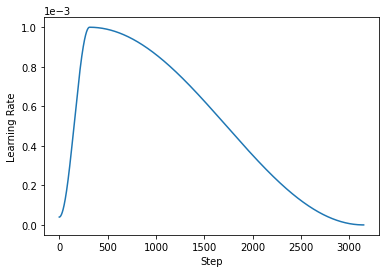

In [88]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 5
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    epoch_lrs = []
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# <b><span style='color:#F1A424'>|</span> Loss Function</b><a class='anchor' id='loss'></a> [↑](#top) 

***

In PyTorch's [KLDivLoss][1], the reduction parameter determines how the loss is aggregated across different dimensions. Two common options are `mean` and `batchmean`.

- `reduction`='mean': When reduction is set to "mean", the Kullback-Leibler Divergence loss is computed and then averaged over all the elements in the input tensor. The result is a scalar value representing the mean loss.
- `reduction`='batchmean': When reduction is set to "batchmean", the Kullback-Leibler Divergence loss is computed independently for each item in the batch, and then the mean is taken over the batch dimension. This is useful when you have a batch of samples, and you want the average loss per sample.

[1]: https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html


In [90]:
import torch.nn.functional as F

# === Reduction = "mean" ===
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(torch.randn(6, 2, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(6, 2), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

print("\n", "="*100, "\n")

# === Reduction = "batchmean" ===
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(torch.randn(2, 6, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(2, 6), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

Predictions: tensor([[-1.6370, -0.2164],
        [-0.6403, -0.7489],
        [-0.5968, -0.7998],
        [-0.5062, -0.9232],
        [-0.6922, -0.6941],
        [-2.2043, -0.1169]], grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.6302, 0.3698],
        [0.4935, 0.5065],
        [0.5837, 0.4163],
        [0.5098, 0.4902],
        [0.5932, 0.4068],
        [0.3708, 0.6292]])
Output: 0.0603087842464447


Predictions: tensor([[-2.1677, -2.6695, -1.6717, -2.5429, -1.2058, -1.3853],
        [-1.4462, -4.0774, -2.3197, -2.4291, -1.5565, -1.0490]],
       grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.1556, 0.1233, 0.2095, 0.1960, 0.1368, 0.1789],
        [0.1776, 0.1073, 0.2004, 0.1172, 0.1915, 0.2060]])
Output: 0.17475900053977966


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***

In [91]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    criterion_contrastive_loss = nn.CosineEmbeddingLoss()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            X_eeg = batch.pop("X_eeg").to(device) # send inputs to `device`
            X_spec = batch.pop("X_spec").to(device) # send inputs to `device`
            y = batch.pop("y").to(device) # send labels to `device`
            batch_size = y.size(0)
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds, eeg_emb, spec_emb, out1d, out2d = model(X_eeg, X_spec)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
                loss2 = criterion(F.log_softmax(out1d, dim=1), y)
                loss3 = criterion(F.log_softmax(out2d, dim=1), y)
                
                embedding_1d = torch.nn.functional.normalize(eeg_emb, p=2, dim=1)
                embedding_2d = torch.nn.functional.normalize(spec_emb, p=2, dim=1)
                contrastive_target = torch.ones(embedding_1d.size(0)).to(device)  # Assuming all pairs are similar
                contrastive_loss1 = criterion_contrastive_loss(embedding_1d, embedding_2d, contrastive_target)
                
                loss = loss + loss2 + loss3 + contrastive_loss1
                
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                # if epoch != 'last':
                scheduler.step()
            end = time.time()

            # # ========== LOG INFO ==========
            # if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
            #     print('Epoch: [{0}][{1}/{2}] '
            #           'Elapsed {remain:s} '
            #           'Loss: {loss.avg:.4f} '
            #           'Grad: {grad_norm:.4f}  '
            #           'LR: {lr:.8f}  '
            #           .format(epoch+1, step, len(train_loader), 
            #                   remain=timeSince(start, float(step+1)/len(train_loader)),
            #                   loss=losses,
            #                   grad_norm=grad_norm,
            #                   lr=scheduler.get_last_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, device):
    model.eval() 
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    criterion = nn.KLDivLoss(reduction="batchmean")
    criterion_contrastive_loss = nn.CosineEmbeddingLoss()
    prediction_dict = {}
    preds, out1d_list, out2d_list = [], [], []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            X_eeg = batch.pop("X_eeg").to(device) # send inputs to `device`
            X_spec = batch.pop("X_spec").to(device) # send inputs to `device
            y = batch.pop("y").to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds, eeg_emb, spec_emb, out1d, out2d = model(X_eeg, X_spec)
                
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
                loss2 = criterion(F.log_softmax(out1d, dim=1), y)
                loss3 = criterion(F.log_softmax(out2d, dim=1), y)
                # loss4 = criterion(F.log_softmax(outwavenet, dim=1), y)
                
                embedding_1d = torch.nn.functional.normalize(eeg_emb, p=2, dim=1)
                embedding_2d = torch.nn.functional.normalize(spec_emb, p=2, dim=1)
                contrastive_target = torch.ones(embedding_1d.size(0)).to(device)  # Assuming all pairs are similar
                contrastive_loss1 = criterion_contrastive_loss(embedding_1d, embedding_2d, contrastive_target)
                
                loss = loss + loss2 + loss3 + contrastive_loss1
                
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = softmax(y_preds)
            out1d = softmax(out1d)
            out2d = softmax(out2d)
            
            preds.append(y_preds.to('cpu').numpy()) 
            out1d_list.append(out1d.to('cpu').numpy()) 
            out2d_list.append(out2d.to('cpu').numpy()) 
            end = time.time()

            # # ========== LOG INFO ==========
            # if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
            #     print('EVAL: [{0}/{1}] '
            #           'Elapsed {remain:s} '
            #           'Loss: {loss.avg:.4f} '
            #           .format(step, len(valid_loader),
            #                   remain=timeSince(start, float(step+1)/len(valid_loader)),
            #                   loss=losses))
                
    prediction_dict["predictions"] = np.concatenate(preds)
    prediction_dict["out1d"] = np.concatenate(out1d_list)
    prediction_dict["out2d"] = np.concatenate(out2d_list)
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [93]:
def train_loop(df, fold, two_stage=False):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    if two_stage:
        train_folds = df[(df['fold'] != fold) & (df['total_evaluators'] >= 10)].reset_index(drop=True)
    else:
        train_folds = df[(df['fold'] != fold)].reset_index(drop=True)
        
    valid_folds = df[(df['fold'] == fold)].reset_index(drop=True)
    
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, config, mode="train")
    valid_dataset = CustomDataset(valid_folds, config, mode="valid")
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = EEGMegaNet(backbone_2d=config.backbone_2d,kernels=[3,5,7,9], in_channels=8, fixed_kernel_size=5,
           num_classes=6)
    
    if two_stage:
        checkpoint = torch.load(f"{paths.OUTPUT_DIR}/wavenet_fold_{fold}_best.pth")
        model.load_state_dict(checkpoint["model"])
        
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )


    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)
        
        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, device)
        predictions = prediction_dict["predictions"]
        out1d = prediction_dict["out1d"]
        out2d = prediction_dict["out2d"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  lr: {scheduler.get_last_lr()[0]:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch} - Save Best Loss: {best_loss:.4f} Model')
            if two_stage:
                torch.save({'model': model.state_dict(),
                            'predictions': predictions,
                            'out1d': out1d,
                            'out2d': out2d
                           },
                             f"{paths.OUTPUT_DIR}/wavenet_fold_{fold}_best_s2_val_by10.pth")
            else:
                torch.save({'model': model.state_dict(),
                            'predictions': predictions,
                            'out1d': out1d,
                            'out2d': out2d
                           },
                             f"{paths.OUTPUT_DIR}/wavenet_fold_{fold}_best.pth")
    if two_stage:
        loaded_model = torch.load(f"{paths.OUTPUT_DIR}/wavenet_fold_{fold}_best_s2_val_by10.pth", 
                                 map_location=torch.device('cpu'))
    else:
        loaded_model = torch.load(f"{paths.OUTPUT_DIR}/wavenet_fold_{fold}_best.pth", 
                                 map_location=torch.device('cpu'))    
        
    predictions = loaded_model['predictions']
    out1d = loaded_model['out1d']
    out2d = loaded_model['out2d']
    valid_folds[[i+'preds' for i in target_preds]] = predictions
    valid_folds[[i+'out1d' for i in target_preds]] = out1d
    valid_folds[[i+'out2d' for i in target_preds]] = out2d

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [38]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result


oof_df = pd.DataFrame()
for fold in range(config.FOLDS):
    if fold in [0, 1, 2, 3, 4]:
        _oof_df = train_loop(train_df, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== Fold {fold} finished =======sep===")
oof_df = oof_df.reset_index(drop=True)
oof_df.to_csv(f'{paths.OUTPUT_DIR}/oof_df.csv', index=False)

========== Fold: 0 training ==========
Validation: 100%|██████████| 127/127 [03:06<00:00,  1.47s/valid_batch]
Epoch 0 - avg_train_loss: 2.7716  avg_val_loss: 2.5568  lr: 0.0010  time: 1052s
Epoch 0 - Save Best Loss: 2.5568 Model
Validation: 100%|██████████| 127/127 [03:11<00:00,  1.51s/valid_batch]
Epoch 1 - avg_train_loss: 1.8642  avg_val_loss: 2.1847  lr: 0.0007  time: 1050s
Epoch 1 - Save Best Loss: 2.1847 Model
Validation: 100%|██████████| 127/127 [03:05<00:00,  1.46s/valid_batch]
Epoch 2 - avg_train_loss: 1.5931  avg_val_loss: 2.2017  lr: 0.0004  time: 1058s
Validation: 100%|██████████| 127/127 [03:06<00:00,  1.47s/valid_batch]
Epoch 3 - avg_train_loss: 1.3533  avg_val_loss: 2.0380  lr: 0.0001  time: 1049s
Epoch 3 - Save Best Loss: 2.0380 Model
Validation: 100%|██████████| 127/127 [03:09<00:00,  1.49s/valid_batch]
Epoch 4 - avg_train_loss: 1.1714  avg_val_loss: 2.0660  lr: 0.0000  time: 1048s
========== Fold 0 finished =======sep===
========== Fold: 1 training ==========
Validatio

In [40]:
pred1=oof_df[[i+'preds' for i in target_preds]]
pred2=oof_df[[i+'out1d' for i in target_preds]]
pred3=oof_df[[i+'out2d' for i in target_preds]]
p1 = pd.DataFrame(pred1.copy())
p2 = pd.DataFrame(pred2.copy())
p3 = pd.DataFrame(pred3.copy())
p1.columns = label_cols
p2.columns = label_cols
p3.columns = label_cols

In [41]:
import sys
sys.path.append('kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = label_cols.tolist()
gt = train_df[["eeg_id"] + label_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

def cal_score(i):
    i = i.iloc[oof_df.index]
    i['eeg_id'] = oof_df['eeg_id']
    preds = i[["eeg_id"] + label_cols]
    preds.columns = ["eeg_id"] + label_cols
    preds.sort_values(by="eeg_id", inplace=True)
    preds.reset_index(inplace=True, drop=True)

    y_trues = gt[label_cols]
    y_preds = preds[label_cols]

    oof = pd.DataFrame(y_preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(y_trues.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    # print(f'CV Score with Ensemble Model = {cv}')
    return cv

/tmp/ipykernel_170658/3663444947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt.sort_values(by="eeg_id", inplace=True)


In [42]:
cv_list = []
res = []
for i in [p1, p2, p3]:
# for i in [p1]:
    cv = cal_score(i)
    res.append(round(cv,3))
    cv_list.append(1/cv)
    
    
optimized_weights = [round(i/sum(cv_list),3) for i in cv_list]

w1 = optimized_weights[0]
w2 = optimized_weights[1]
w3 = optimized_weights[2]
fused_pred = (w1 * p1 + w2 * p2 + w3 * p3) / (w1 + w2 + w3)
fused_pred['eeg_id'] = oof_df['eeg_id']
print(optimized_weights)
print(round(cal_score(fused_pred),3))
print(res)

[0.381, 0.25, 0.369]
0.546
[0.554, 0.844, 0.573]


In [95]:
config.two_stage = True
if config.two_stage:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold, config.two_stage)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== Fold {fold} finished =======sep===")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv(f'{paths.OUTPUT_DIR}/oof_df_s2_val.csv', index=False)

========== Fold: 0 training ==========
========== Fold: 0 training ==========
Train:   0%|          | 0/152 [00:00<?, ?train_batch/s]/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Validation: 100%|██████████| 46/46 [01:05<00:00,  1.43s/valid_batch]
Epoch 0 - avg_train_loss: 0.9712  avg_val_loss: 1.4397  lr: 0.0010  time: 324s
Epoch 0 - avg_train_loss: 0.9712  avg_val_loss: 1.4397  lr: 0.0010  time: 324s
Epoch 0 - Save Best Loss: 1.4397 Model
Epoch 0 - Save Best Loss: 1.4397 Model
Validatio

In [97]:
if config.two_stage:

    pred1=oof_df[[i+'preds' for i in target_preds]]
    pred2=oof_df[[i+'out1d' for i in target_preds]]
    pred3=oof_df[[i+'out2d' for i in target_preds]]
    p1 = pd.DataFrame(pred1.copy())
    p2 = pd.DataFrame(pred2.copy())
    p3 = pd.DataFrame(pred3.copy())
    p1.columns = label_cols
    p2.columns = label_cols
    p3.columns = label_cols

    import sys
    sys.path.append('kaggle-kl-div')
    from kaggle_kl_div import score

    # === Pre-process OOF ===
    # gt = train_df[train_df['total_evaluators'] >= 10][["eeg_id"] + label_cols]
    gt = train_df[["eeg_id"] + label_cols]
    
    gt.sort_values(by="eeg_id", inplace=True)
    gt.reset_index(inplace=True, drop=True)

    def cal_score(i):
        i = i.iloc[oof_df.index]
        i['eeg_id'] = oof_df['eeg_id']
        preds = i[["eeg_id"] + label_cols]
        preds.columns = ["eeg_id"] + label_cols
        preds.sort_values(by="eeg_id", inplace=True)
        preds.reset_index(inplace=True, drop=True)

        y_trues = gt[label_cols]
        y_preds = preds[label_cols]

        oof = pd.DataFrame(y_preds.copy())
        oof['id'] = np.arange(len(oof))

        true = pd.DataFrame(y_trues.copy())
        true['id'] = np.arange(len(true))

        cv = score(solution=true, submission=oof, row_id_column_name='id')
        # print(f'CV Score with Ensemble Model = {cv}')
        return cv

    cv_list = []
    res = []
    for i in [p1, p2, p3]:
    # for i in [p1]:
        cv = cal_score(i)
        res.append(round(cv,3))
        cv_list.append(1/cv)


    optimized_weights = [round(i/sum(cv_list),3) for i in cv_list]

    w1 = optimized_weights[0]
    w2 = optimized_weights[1]
    w3 = optimized_weights[2]
    fused_pred = (w1 * p1 + w2 * p2 + w3 * p3) / (w1 + w2 + w3)
    fused_pred['eeg_id'] = oof_df['eeg_id']
    print(optimized_weights)
    print(round(cal_score(fused_pred),3))
    print(res)

[0.313, 0.386, 0.301]
0.675
[0.8, 0.649, 0.833]


/tmp/ipykernel_180014/3342662918.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt.sort_values(by="eeg_id", inplace=True)


In [ ]:
# cv_list = [1/cv_v12, 1/cv_v16, 1/cv_v17, 1/cv_v70_newdata_re]
# p_list = [fused_pred_v12, fused_pred_v16, fused_pred_v17,fused_pred_v70_newdata_re]
# optimized_weights = [round(i/sum(cv_list),4) for i in cv_list]
# w1 = optimized_weights[0]
# w2 = optimized_weights[1]
# w3 = optimized_weights[2]
# w4 = optimized_weights[3]
# fused_pred = (w1 * p_list[0] + w2 * p_list[1] + w3 * p_list[2] + w4 * p_list[3]) / (w1 + w2 + w3 + w4)
# fused_pred['eeg_id'] = oof_df['eeg_id']

# print(optimized_weights)
# print(round(cal_score(fused_pred, s2=True),4))